# Day 19: Copulas

---

- CDF transforms
  - Uniform to X
  - X to Uniform
  - Examples
- Copulas
  - Key idea
  - Skylar's theorem
  - Grama __feature__: error if copula not defined!
- Practical tips
  - Use data if you have it
  - Scenario testing
  - You don't always need a copula


In [1]:
import pandas as pd 
import grama as gr 
import numpy as np

from scipy.stats import lognorm
from plotnine import *

DF = gr.Intention()


## CDF Transforms

---

A uniform random variable $U$ on the unit interval $U \in [0, 1]$ has a very simple CDF:

$$F_U(u) = u\text{ for }u\in[0,1]$$


Suppose $X \sim F_X$ with $F_X(x)$ invertible. The CDF is defined as.

$$F_X(x) = \mathbb{P}[X \leq x]$$

Define a new random variable via CDF transform:

$$U = F(X)$$


Then this new variable is distributed as $U \sim U(0, 1)$, which we can see via:

$$\mathbb{P}[U \leq u] = \mathbb{P}[F(X) \leq u] = \mathbb{P}[X \leq F^{-1}(u)] = F_X\left(F_X^{-1}(u)\right) = u$$


> We can transform any random variable $X$ into a uniform random variable $U \sim U(0, 1)$ via its CDF $F_X(\cdot)$


Now imagine we start with a uniform random variable $U \sim U(0, 1)$. Let $F_Y(y)$ be a valid CDF, and define

$$Y = F_Y^{-1}(U).$$

Then

$$\mathbb{P}[Y \leq y] = \mathbb{P}[F_Y^{-1}(U) \leq y] = \mathbb{P}[U \leq F_Y(y)] = F_Y(y)$$

which implies that $Y \sim F_Y$.


> Given a uniform random variable $U$ and a valid inverse CDF $F_Y^{-1}(\cdot)$, we can generate a new random variable distributed as $Y \sim F_Y$.


### Computational example

Here's an example mapping a normal distribution to a uniform distribution.


eval_monte_carlo() is rounding n...


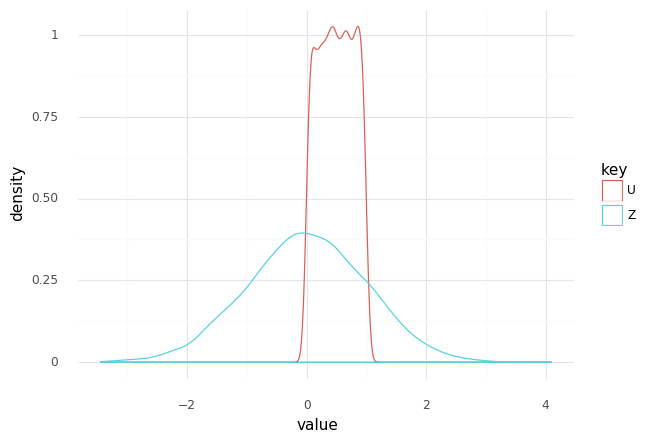

<ggplot: (8766863366885)>

In [8]:
(
    gr.Model()
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(U=gr.pnorm(df.Z)),
        var=["Z"],
        out=["U"],
    )
    >> gr.cp_marginals(Z=dict(dist="norm", loc=0, scale=1))
    >> gr.cp_copula_independence()
    
    >> gr.ev_monte_carlo(n=5e3, df_det="nom", seed=101)
    >> gr.tf_gather("key", "value", ["Z", "U"])
    
    >> ggplot(aes("value"))
    + geom_density(aes(color="key"))
#     + facet_wrap("key")
    + theme_minimal()
)

eval_monte_carlo() is rounding n...


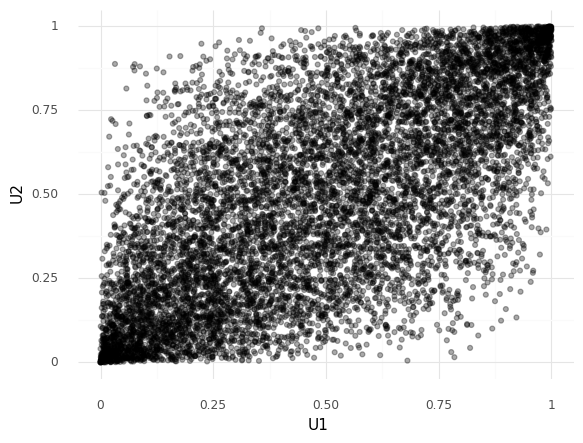

<ggplot: (8766839748765)>

In [26]:
p = (
    gr.Model()
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(
            U1=gr.pnorm(df.Z1),
            U2=gr.pnorm(df.Z2 / 2),
        ),
        var=["Z1", "Z2"],
        out=["U1", "U2"],
    )
    >> gr.cp_marginals(
        Z1=dict(dist="norm", loc=0, scale=1),
        Z2=dict(dist="norm", loc=0, scale=2),
    )
    >> gr.cp_copula_gaussian(
        df_corr=gr.df_make(
            var1=["Z1"],
            var2=["Z2"],
            corr=[0.7],
        )
    )
    
    >> gr.ev_monte_carlo(n=1e4, df_det="nom", seed=101)
    
#     >> ggplot(aes("Z1", "Z2"))
    >> ggplot(aes("U1", "U2"))
    + geom_point(alpha=1/3)
    + theme_minimal()
    + theme(panel_background=element_rect(fill="white"))
)
# ggsave(p, "./images/corr-gaussian.png")
ggsave(p, "./images/corr-copula.png")
p

This is an example of a *gaussian copula*


## Copulas

---

*Copula* is [borrowed from Latin](https://en.wiktionary.org/wiki/copula), meaning "connection." The $Z_1, Z_2 \to U_1, U_2$ mapping we saw above is an example of a copula. A [copula](https://en.wikipedia.org/wiki/Copula_(probability_theory)) is essentially a way to generate samples from a multivariate uniform distribution with a specified dependency structure. We can then use the inverse CDF transform to give the marginals a desired shape.

> Key Idea: Marginals $F_{X_i}$ give a distribution its shape, a copula $C(u_1, \dots, u_d)$ defines its dependence structure.


[Skylar's theorem](https://en.wikipedia.org/wiki/Copula_(probability_theory)#Sklar's_theorem) provides theoretical justification for the use of copula models:

> *Theorem (Skylar)*: Let $F(x_1, \dots, x_d)$ be a multivariate CDF. Then there exist marginals $F_i$ and a copula $C(u_1, \dots, u_d)$ such that
> 
> $$F(x_1, \dots, x_d) = C(F_1(x_1), \dots, F_d(x_d)).$$

Important caveat: While an appropriate copula always exists, the *gaussian copula* is not always the appropriate copula. However, it is a simple "first pass" tool you can use.


### A Grama feature (not a bug!)

Notice that if you *do not* define a copula for a Grama model and attempt to perform Monte Carlo, you will get the following error:


In [27]:
(
    gr.Model()
    >> gr.cp_marginals(
        x=dict(dist="norm", loc=0, scale=1),
        y=dict(dist="lognorm", loc=0, scale=1, s=1),
    )
    
    >> gr.ev_monte_carlo(n=100, df_det="nom", skip=True)
)

ValueError: 
Present model copula must be defined for sampling.
Use CopulaIndependence only when inputs can be guaranteed
independent. See the Documentation chapter on Random
Variable Modeling for more information.

As the `ValueError` suggests, you should **only** use an independence copula when you can **guarantee** all of your random variables are completely independent. If you can't guarantee this, then you can use a gaussian copula to introduce some dependency.


## Practical Tips

---



### Copula correlation is *not equal* to data correlation


In [55]:
(
    gr.Model()
    >> gr.cp_marginals(
        X1=dict(dist="lognorm", loc=0, scale=1, s=1),
        X2=dict(dist="lognorm", loc=0, scale=1, s=1),
    )
    >> gr.cp_copula_gaussian(
        df_corr=gr.df_make(
            var1=["X1"],
            var2=["X2"],
            corr=[0.7],
        )
    )
    ## Assess data correlation
    >> gr.ev_monte_carlo(n=1e5, df_det="nom", seed=101, skip=True)
    >> gr.tf_summarize(
        rho=gr.corr(DF.X1, DF.X2)
    )
)


eval_monte_carlo() is rounding n...
Design runtime estimates unavailable; model has no timing data.


,rho
0,0.588361


Here the gaussian copula correlation is `0.7`, but the correlation between `X1, X2` is only about `0.59`. The gaussian copula correlation has a *complicated relationship* with the marginals' correlation.


### Use data if you have it


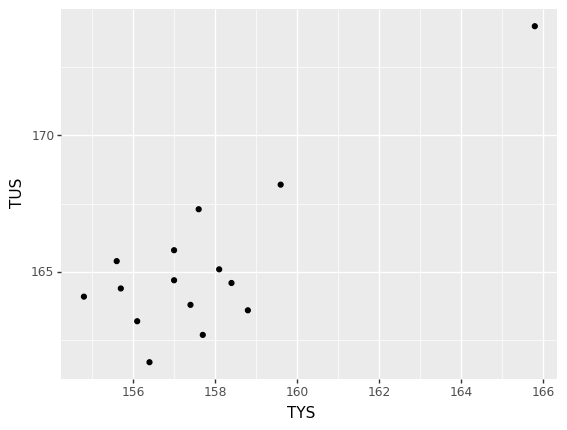

<ggplot: (8766839408921)>

In [29]:
from grama.data import df_ruff

(
    df_ruff
    >> ggplot(aes("TYS", "TUS"))
    + geom_point()
)

In [32]:
md_ruff_copula = (
    gr.Model("Ruff material properties")
    >> gr.cp_marginals(
        TYS=gr.marg_named(df_ruff.TYS, "lognorm"),
        TUS=gr.marg_named(df_ruff.TUS, "lognorm"),
    )
    >> gr.cp_copula_gaussian(df_data=df_ruff)
)
md_ruff_copula


model: Ruff material properties

  inputs:
    var_det:

    var_rand:
      TYS: (+0) lognorm, {'s': 0.5452819189243673, 'loc': 153.7316068729366, 'scale': 3.434962095962383}
      TUS: (+0) lognorm, {'s': 0.5090878746308491, 'loc': 160.2761533275666, 'scale': 4.34530057914359}

    copula:
      Gaussian copula with correlations:
  var1 var2      corr
0  TUS  TYS  0.513831

  functions:

eval_monte_carlo() is rounding n...
Design runtime estimates unavailable; model has no timing data.


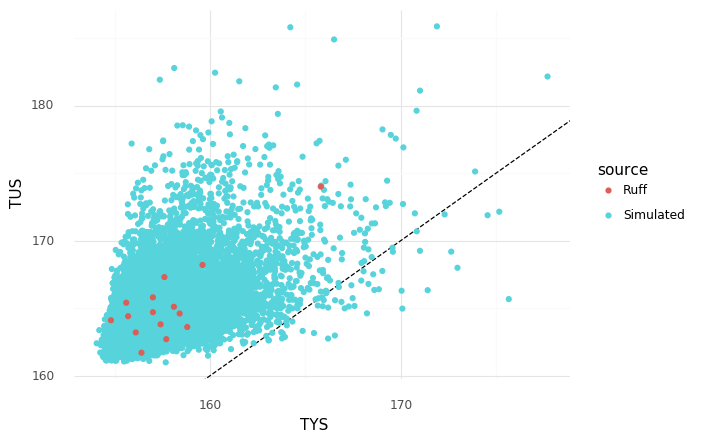

<ggplot: (8766862367613)>

In [35]:
(
    md_ruff_copula
    >> gr.ev_monte_carlo(n=1e4, df_det="nom", skip=True)
    >> gr.tf_mutate(source="Simulated")
    >> gr.tf_bind_rows(
        df_ruff
        >> gr.tf_mutate(source="Ruff")
    )
    
    >> ggplot(aes("TYS", "TUS", color="source"))
    + geom_abline(slope=1, intercept=0, linetype="dashed")
    + geom_point()
    + theme_minimal()
)

The model seems plausible for the data we have available. However, it does not respect the fact that $TYS \leq TUS$.


### Correlation scenario testing

Remember from the homework that the correlation is very different in `df_ruff` if you include / exclude the outlier:


In [42]:
## With outlier
(
    df_ruff
    >> gr.tf_summarize(
        rho=gr.corr(DF.TYS, DF.TUS)
    )
)


,rho
0,0.820159


In [43]:
## Without outlier
(
    df_ruff
    >> gr.tf_filter(DF.TYS <= 164)
    >> gr.tf_summarize(
        rho=gr.corr(DF.TYS, DF.TUS)
    )
)


,rho
0,0.375356


It's a hard choice to decide whether or not to include the outlier. So why not simply test both options?


In [44]:
md_ruff_filtered = (
    gr.Model("Ruff material properties")
    >> gr.cp_marginals(
        TYS=gr.marg_named(df_ruff.TYS, "lognorm"),
        TUS=gr.marg_named(df_ruff.TUS, "lognorm"),
    )
    >> gr.cp_copula_gaussian(
        df_data=df_ruff
        >> gr.tf_filter(DF.TYS <= 164)
    )
)
md_ruff_filtered


model: Ruff material properties

  inputs:
    var_det:

    var_rand:
      TYS: (+0) lognorm, {'s': 0.5452819189243673, 'loc': 153.7316068729366, 'scale': 3.434962095962383}
      TUS: (+0) lognorm, {'s': 0.5090878746308491, 'loc': 160.2761533275666, 'scale': 4.34530057914359}

    copula:
      Gaussian copula with correlations:
  var1 var2      corr
0  TUS  TYS  0.226076

  functions:

Compare the models in terms of their densities:


eval_monte_carlo() is rounding n...
Design runtime estimates unavailable; model has no timing data.
eval_monte_carlo() is rounding n...
Design runtime estimates unavailable; model has no timing data.


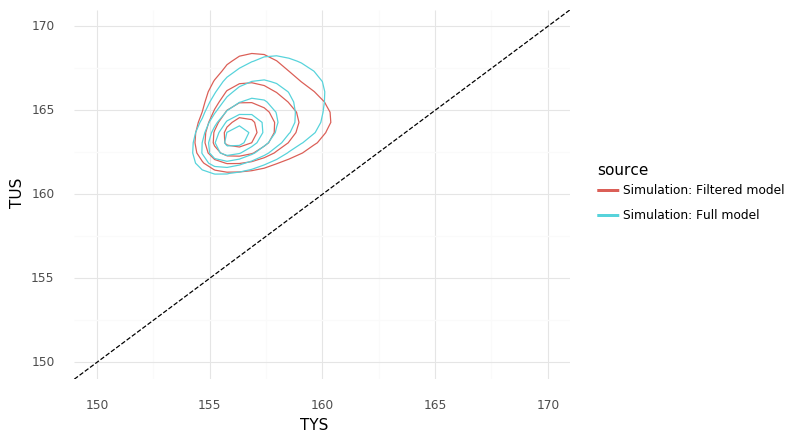

<ggplot: (8766837500297)>

In [47]:
(
    md_ruff_copula
    >> gr.ev_monte_carlo(n=1e4, df_det="nom", skip=True)
    >> gr.tf_mutate(source="Simulation: Full model")
    >> gr.tf_bind_rows(
        md_ruff_filtered
        >> gr.ev_monte_carlo(n=1e4, df_det="nom", skip=True)
        >> gr.tf_mutate(source="Simulation: Filtered model")
    )
    
    >> ggplot(aes("TYS", "TUS", color="source"))
    + geom_abline(slope=1, intercept=0, linetype="dashed")
#     + geom_point()
    + geom_density_2d()
    + coord_cartesian(xlim=(150, 170), ylim=(150, 170))
    + theme_minimal()
)

**Most important**: Compare the models **in terms of the relevant performance metrics**:


In [59]:
(
    md_ruff_copula
    >> gr.ev_monte_carlo(n=1e5, df_det="nom", skip=True)
    >> gr.tf_mutate(source="Simulation: Full model")
    >> gr.tf_bind_rows(
        md_ruff_filtered
        >> gr.ev_monte_carlo(n=1e5, df_det="nom", skip=True)
        >> gr.tf_mutate(source="Simulation: Filtered model")
    )
    
    >> gr.tf_group_by(DF.source)
    >> gr.tf_mutate(I_fail = DF.TUS < 162)
    >> gr.tf_summarize(
        pof_lo=gr.binomial_ci(DF.I_fail, side="lo"),
        pof_mu=gr.mean(DF.I_fail),
        pof_up=gr.binomial_ci(DF.I_fail, side="up"),
    )
)

eval_monte_carlo() is rounding n...
Design runtime estimates unavailable; model has no timing data.
eval_monte_carlo() is rounding n...
Design runtime estimates unavailable; model has no timing data.


,source,pof_lo,pof_mu,pof_up
0,Simulation: Filtered model,0.034410,0.03554,0.036705
1,Simulation: Full model,0.034213,0.03534,0.036502


The two models have a difference in POF estimate only in their third (significant) decimal place; there does not seem to be a great deal of difference in filtering the outlier for this case. So this particular modeling decision is not consequential for this specific POF calculation: We should make a choice between the two and move on.


### You don't always need a copula!


In [38]:
df_mod = (
    df_ruff
    >> gr.tf_mutate(delta=DF.TUS - DF.TYS)
)

md_ruff_diff = (
    gr.Model("Ruff material properties; difference model")
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(
            TUS=df.TYS + df.delta,
        ),
        var=["TYS", "delta"],
        out=["TUS"],
    )
    >> gr.cp_marginals(
        TYS=gr.marg_named(df_mod.TYS, "lognorm"),
        delta=gr.marg_named(df_mod.delta, "norm")
    )
    >> gr.cp_copula_independence()
#     >> gr.cp_copula_gaussian(df_data=df_mod)
)
md_ruff_diff


model: Ruff material properties; difference model

  inputs:
    var_det:

    var_rand:
      TYS: (+0) lognorm, {'s': 0.5452819189243673, 'loc': 153.7316068729366, 'scale': 3.434962095962383}
      delta: (+0) norm, {'loc': 7.506666666666664, 'scale': 1.6315500469049593}

    copula:
      Independence copula

  functions:
      f0: ['TYS', 'delta'] -> ['TUS']

eval_monte_carlo() is rounding n...


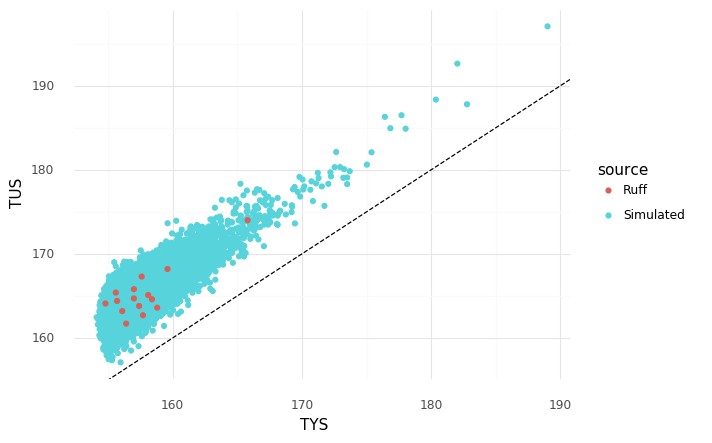

<ggplot: (8766837852633)>

In [40]:
(
    md_ruff_diff
    >> gr.ev_monte_carlo(n=1e4, df_det="nom")
    >> gr.tf_mutate(source="Simulated")
    >> gr.tf_bind_rows(
        df_ruff
        >> gr.tf_mutate(source="Ruff")
    )
    
    >> ggplot(aes("TYS", "TUS", color="source"))
    + geom_abline(slope=1, intercept=0, linetype="dashed")
    + geom_point()
    + theme_minimal()
)

This model seems plausible; it exhibits a much stronger correlation between TYS and TUS, and largely respects the principle that $TYS \leq TUS$.
